# Blood Glucose Control - EDA

**Name:** [Ahyan Kabir]



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [ ]:
import pandas as pd
# reading separate patient files
df1 = pd.read_csv('../data/gluroo_500030.csv')
df2 = pd.read_csv('../data/gluroo_679372.csv')

# adding identifiers to distinguish between PWDs
df1['pwd_id'] = '500030'
df2['pwd_id'] = '679372'

# combining dfs
df = pd.concat([df1, df2])

# removing ignorable columns
df = df.drop(columns=['sender_id', 'message_basal_change'])


### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet.

**Visualisation #1**
I initially wanted to compare bgl changes after automatic and manual insulin doses to understand how these methods differ in the modern day. However, since the patient data given does not contain automatic dosing, I decided to focus on visualizing the change in bgl from a meal to the highest bgl before the next meal. This change will be compared with the meal's carbohydrate content in a scatterplot to see how carbs affect bgl spikes.

**Purpose:** could help improve automatic insulin regulation methods by allowing patients to input their next meal's carb count (modelling), and the device could inject the required amount of insulin based on the PWD's current bgl level and their bgl change trends after meals (useful for the PWD).

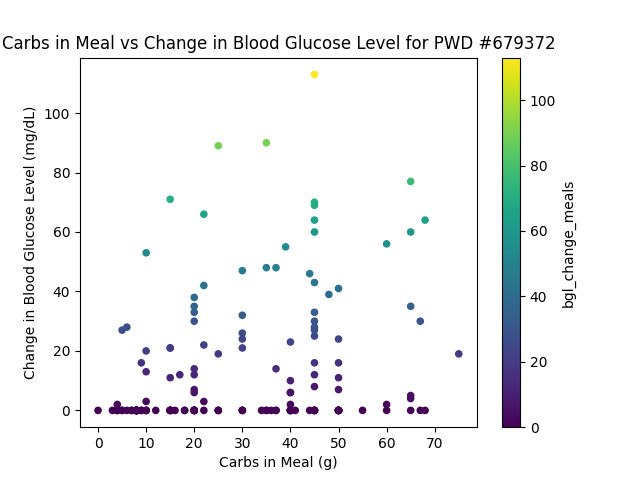

In [1]:
import matplotlib.pyplot as plt

dfs = list([df1, df2])
pwd_ids = list(['500030', '679372'])

def prepare_df(df):
  # clean data
  df = df.drop(columns=['sender_id', 'message_basal_change'])

  # initialise column for containing the max bgl in between meals
  df['bgl_change_meals'] = None

  # df for normal-GI (0.5) meal timestamps
  df_meals = df[(df['msg_type'] == 'ANNOUNCE_MEAL')]

  # all indices of meal announcements
  indices = df_meals.index.tolist()

  # iterating through all meal announcements to find change in bgl from a meal to the max bgl before the next meal
  for index in range(len(indices) - 1):

    bgl_max = df_meals.loc[indices[index]:indices[index + 1], 'bgl'].max()
    bgl_change = bgl_max - df_meals.loc[indices[index], 'bgl']

    df.at[indices[index], 'bgl_change_meals'] = bgl_change

  return df

for df, pwd in zip(dfs, pwd_ids):

  df = prepare_df(df)

  # plot formatting
  df.plot.scatter(x='food_g', y='bgl_change_meals', c='bgl_change_meals', cmap = 'viridis')
  plt.xlabel('Carbs in Meal (g)')
  plt.ylabel('Change in Blood Glucose Level (mg/dL)')
  plt.title('Carbs in Meal vs Change in Blood Glucose Level for PWD #' + pwd)


**Interpretation & Takeaways**

- Many meals are being accounted for through manual bolus insulin injections by the PWD (indicated by a change of 0).
- However, many meals may not be properly accounted for beforehand (indicated by a change >0).
- There is a lot of variability in the change after meals with the same carb level. Additionally, decreases in BGL after meals are not accounted for due to the setup of the scatterplot.
  - It would be much more informative to include a method to also account for minimums past the meal.
  - In addition, the interval for the maximum should not be until the next meal but rather a set amount of hours after each meal.

**Follow-up:** Since this data makes it hard to assess how much insulin should be pumped before a meal of a certain carb content, it would be interesting to see how the data differs when **split into 3 categories:** Breakfast, Lunch, Dinner.

**Visualisation #2** will take a look at the previous data but split into 3 general blocks of time in the day:

- Breakfast: 0:00 to 9:59
- Lunch: 10:00 to 15:59
- Dinner: 16:00 to 23:59


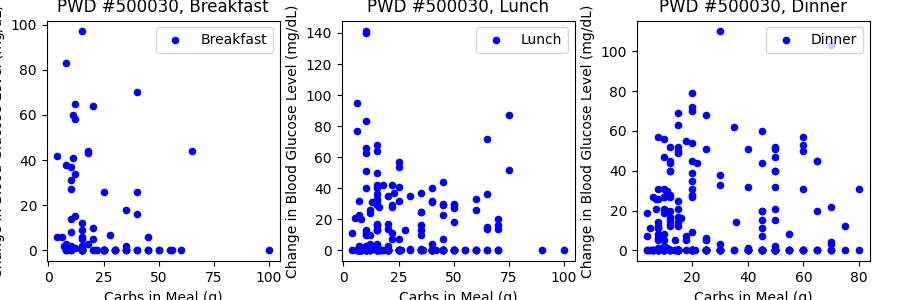

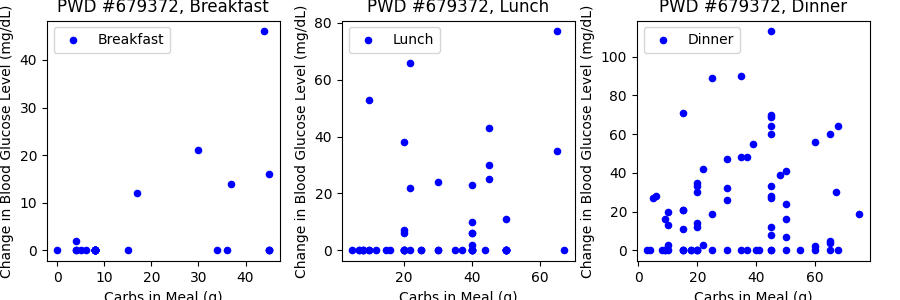

In [ ]:
# defining meal time classifications
breakfast_start = pd.to_datetime('00:00').time()
breakfast_end = pd.to_datetime('09:59').time()
lunch_start = pd.to_datetime('10:00').time()
lunch_end = pd.to_datetime('15:59').time()
dinner_start = pd.to_datetime('16:00').time()
dinner_end = pd.to_datetime('23:59').time()

for df, pwd in zip(dfs, pwd_ids):
  # find bgl_change after each meal as usual
  df = prepare_df(df)

  # initialise column for containing the type of meal
  df['meal_type'] = None,

  # set date strings to datetime values
  df['date'] = pd.to_datetime(df['date'], format = 'mixed')
  df_meals = df[df['msg_type'] == 'ANNOUNCE_MEAL'].copy()
  df_meals['date'] = pd.to_datetime(df_meals['date'], format = 'mixed')

  # all indices of meal announcements
  indices = df_meals.index.tolist()

  for index in range(len(indices) - 1):
    time = df_meals.loc[indices[index], 'date'].time()

    if breakfast_start <= time <= breakfast_end:
        df.at[indices[index], 'meal_type'] = 'Breakfast'
    elif lunch_start <= time <= lunch_end:
        df.at[indices[index], 'meal_type'] = 'Lunch'
    elif dinner_start <= time <= dinner_end:
        df.at[indices[index], 'meal_type'] = 'Dinner'

    df_bk = df[df['meal_type'] == 'Breakfast']
    df_ln = df[df['meal_type'] == 'Lunch']
    df_dn = df[df['meal_type'] == 'Dinner']

  # Plotting in a 1x3 figure (x2)
  fig, axs = plt.subplots(1, 3, figsize=(9, 3))  # Adjust figsize as needed
  plt.tight_layout()

  # for iteration
  meal_type = ['Breakfast', 'Lunch', 'Dinner']
  meal_dfs = [df_bk, df_ln, df_dn]

  # plot for each subset of meal type
  for i, (df_sub, meal_type) in enumerate(zip(meal_dfs, meal_type)):
    ax = axs[i]  # Select subplot
    df_sub['bgl_change_meals'] = df['bgl_change_meals'].reindex(df_sub.index)
    df_sub.plot.scatter(x='food_g', y='bgl_change_meals', ax=ax, label=meal_type, color='blue')
    ax.set_title('PWD #' + pwd + ', ' + meal_type)
    ax.set_xlabel('Carbs in Meal (g)')
    ax.set_ylabel('Change in Blood Glucose Level (mg/dL)')
    ax.legend()


**Interpretation & Takeaways**

- Both patients seem to have the largest spikes in bgl after dinner
  - Could be explained by their insulin dosage and/or the fact that their next meal is after waking up
- Patients seem to be better equipped to handling insulin dosages in the morning rather than before lunch or dinner

These relationships between the carbohydrate content in meals and the respective change in bgl provides some interesting avenues for helping model automatic insulin devices or helping PWDs manage their eating habits. Some improvements include displaying the minimums after meals to account for overdosage and accounting for other activities/snacks that may be causing the spikes.

**Potential Follow-up**
Another visualisation which would be interesting is a time-series graph which compares the average bgl levels up to 3 hours after a breakfast/lunch/dinner meal.


### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. As someone with T1D, how do you manage "Intervention Snacks" with a high-GI as indicated by the datasets? In other words, how do you determine if you can manage a snack or if the snack is worthy of insulin dose(s) beforehand?
2. How do current methods of automatic insulin dosage work (i.e. OP5 pump integration)? How reliable are they in providing the right dosage at the right time?

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`